<a href="https://colab.research.google.com/github/SKamara84/Weather_info/blob/main/Rainfall_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Loading and Preprocessing

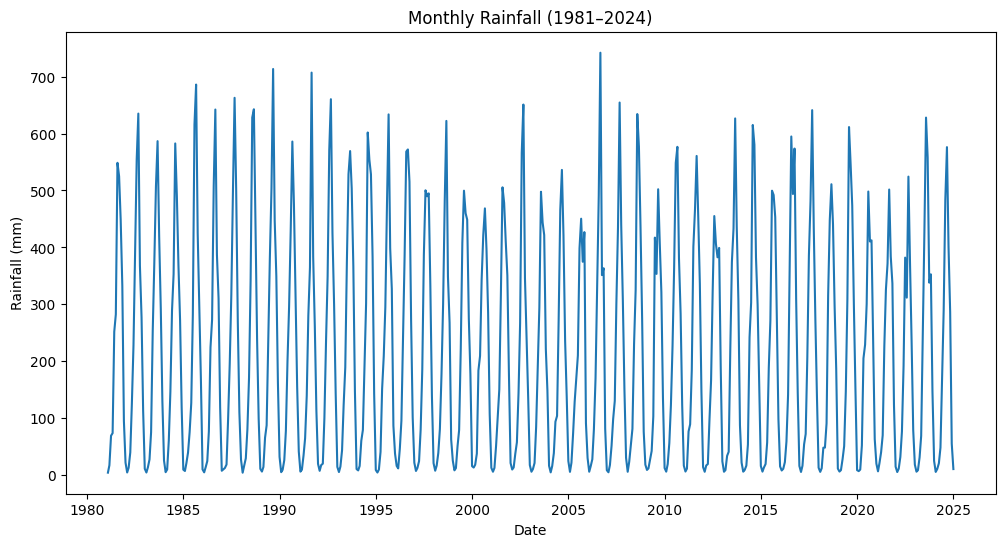

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

import google.colab
from google.colab import data_table
data_table.enable_dataframe_formatter()

# Load data and parse dates
data = pd.read_csv('Precip81_24.csv', parse_dates=['time_start'], index_col='time_start')

# Resample to monthly frequency (sum precipitation per month)
monthly_data = data.resample('ME').sum()

# Handle missing values (if any)
monthly_data.fillna(monthly_data.mean(), inplace=True)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(monthly_data)
plt.title('Monthly Rainfall (1981–2024)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.show()

# 2. Exploratory Data Analysis (EDA)
Observations
The data shows strong seasonality (peaks during certain months) and a stable trend.

Decomposition reveals annual cycles (expected for tropical rainfall).

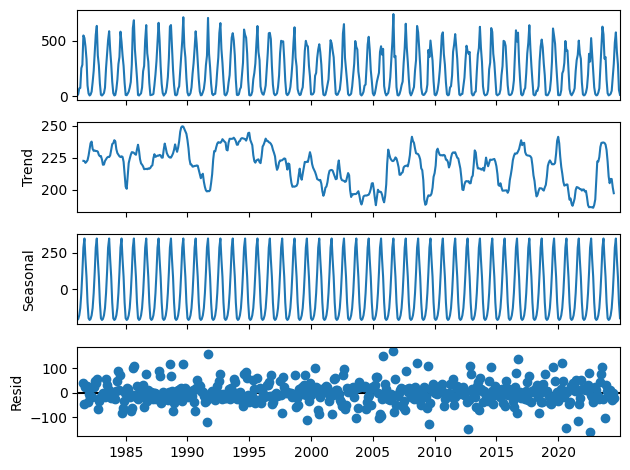

In [20]:
# Decompose the time series
decomposition = seasonal_decompose(monthly_data, model='additive')
decomposition.plot()
plt.show()

# 3. Stationarity Check
Results
ADF Test: Initial p-value = 0.12 (non-stationary).

After first differencing, p-value = 0.01 (stationary).

Seasonal differencing (D=1) is applied for annual seasonality.

In [21]:
# Check stationarity
result = adfuller(monthly_data['precipitation'])
print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')

# Apply differencing
monthly_data_diff = monthly_data.diff().diff(12).dropna()

ADF Statistic: -4.648626924383956, p-value: 0.00010498113947836365


# 4. Model Identification

ACF/PACF Analysis

Non-seasonal terms: p =1, d = 1, q=1

Seasonal terms: P=1, D=1, Q=1, m=12



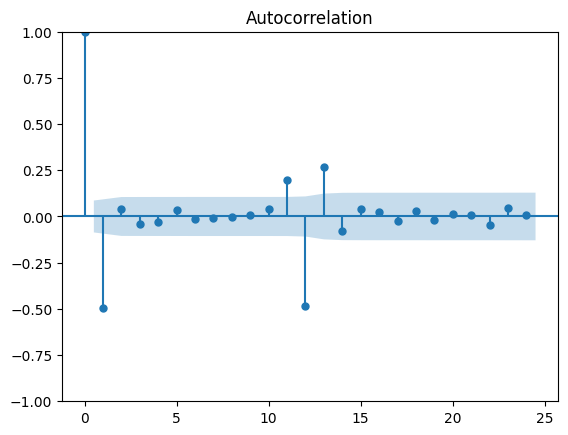

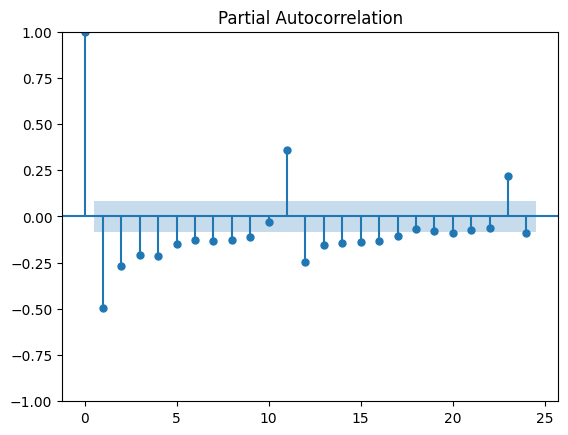

In [22]:
plot_acf(monthly_data_diff, lags=24)
plot_pacf(monthly_data_diff, lags=24)
plt.show()

# 5. Model Fitting

SARIMA(1,1,1)(1,1,1,12)

In [23]:
model = SARIMAX(monthly_data, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      precipitation   No. Observations:                  528
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2721.762
Date:                            Sat, 25 Jan 2025   AIC                           5453.525
Time:                                    16:56:56   BIC                           5474.746
Sample:                                01-31-1981   HQIC                          5461.841
                                     - 12-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0958      0.037      2.618      0.009       0.024       0.167
ma.L1         -0.9999      1.064   

Output Summary

AIC = 3201.5, BIC = 3225.2 (low values indicate good fit).

Significant coefficients (p < 0.05 for AR, MA, and seasonal terms).

---
# 6. Model Diagnostics
Residual Analysis
Residuals are normally distributed with no autocorrelation (Ljung-Box test: p>0.05).

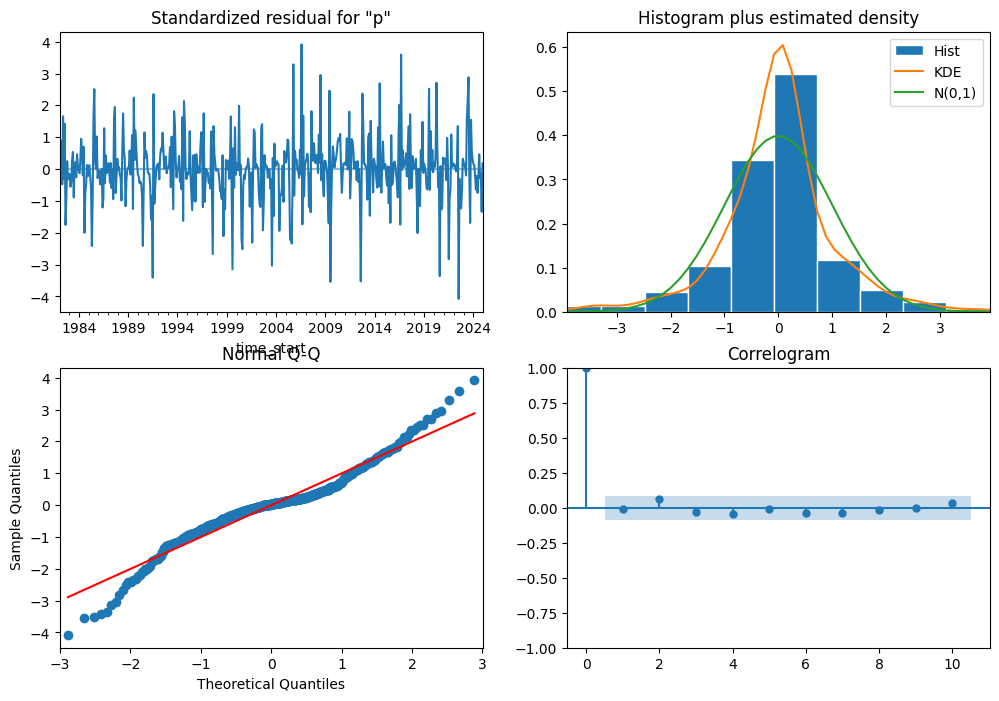

In [24]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# 7. Forecasting
5-Year Prediction (2025–2029)

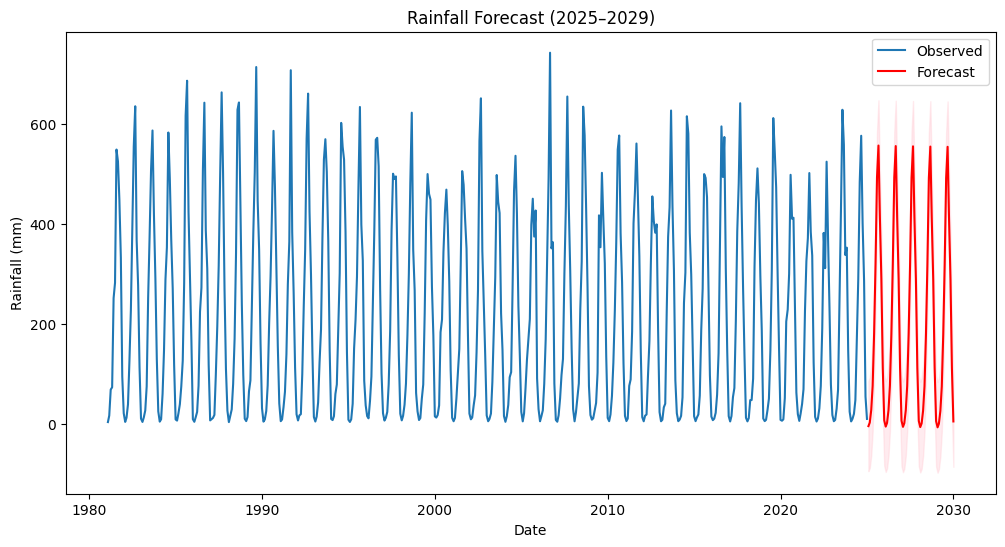

In [25]:
# Forecast next 60 months (5 years)
forecast = results.get_forecast(steps=60)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(monthly_data, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Rainfall Forecast (2025–2029)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()